In [1]:
import pandas as pd
import numpy as np
from prepross import cleaned_fr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

ML Lib:

In [2]:
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Experiment 1

Fitting some basic models and assessing their performance without any parameter fine-tunning.

In [3]:
# Models in experiment 1
models = {
    'BernoulliNB' : BernoulliNB(),
    'GaussianNB' : GaussianNB(),
    'DTr' : DecisionTreeClassifier(),
    'ExTrs': ExtraTreesClassifier(),
    'KNeigh' : KNeighborsClassifier(),
    'NearCentr' : NearestCentroid(),
    'svc': SVC(),
    'logistic' : LogisticRegression(),
    'MLP' : MLPClassifier()
}

In [4]:
# Importing cleaned frame
df = cleaned_fr()

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [5]:
_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    #print("*"*88)
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('scaler', MinMaxScaler()),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)

            try:
                # Some models do not have auc value
                y_proba = _local_pipe.predict_proba(X1)[:, 1]  # Probabilities for the positive class
                _auc.append( roc_auc_score(Y1, y_proba) )
            except:
                _auc.append( np.NaN )
                #print(f"{MODEL_NAME} with PROBA exception")
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [6]:
# Saving in DataFrame
result_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1, 'auc':_auc} )

In [7]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])

set,train,test
model_name,,
BernoulliNB,0.893622,0.890267
DTr,0.920281,0.883576
ExTrs,0.920281,0.886664
GaussianNB,0.920259,0.917693
KNeigh,0.917249,0.902545
MLP,0.919801,0.916880
NearCentr,0.896776,0.896772
logistic,0.898568,0.897380
svc,0.922178,0.916177


In [8]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])*100

set,train,test
model_name,,
BernoulliNB,1.878098,3.715739
DTr,1.723504,5.339241
ExTrs,1.723504,5.184060
GaussianNB,1.536121,3.880218
KNeigh,1.926455,3.928617
MLP,1.775470,3.741828
NearCentr,1.784173,3.562909
logistic,1.742198,3.644113
svc,1.724346,3.639790


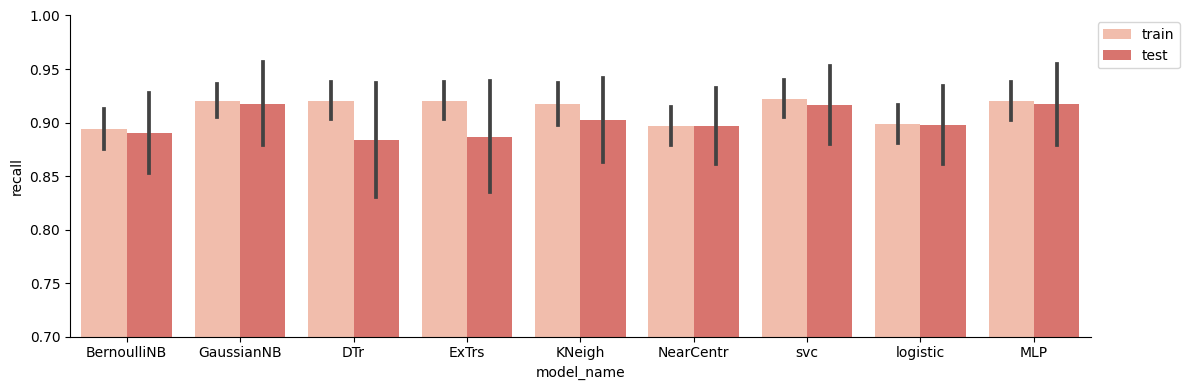

In [9]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment1_recall.png', dpi=200 )
plt.show()

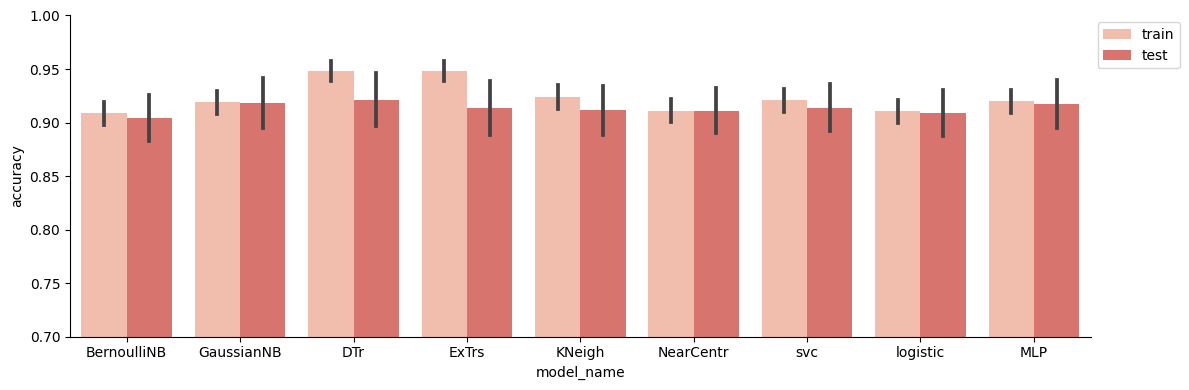

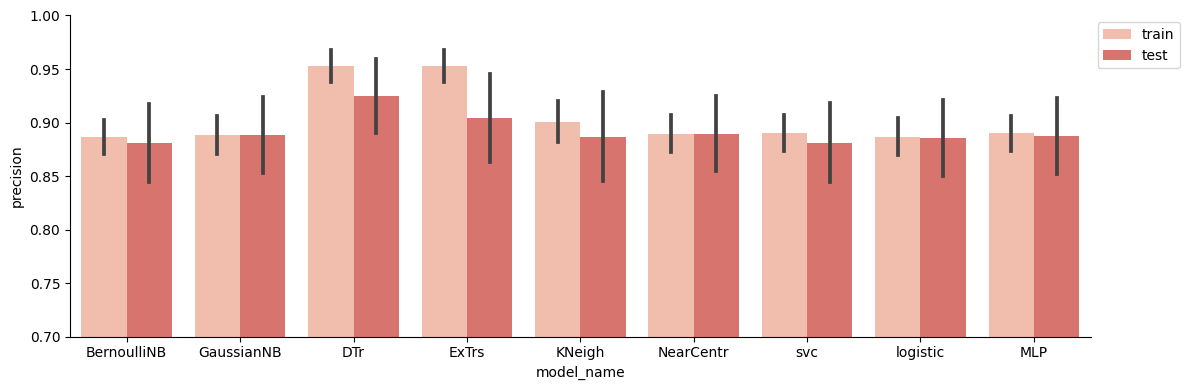

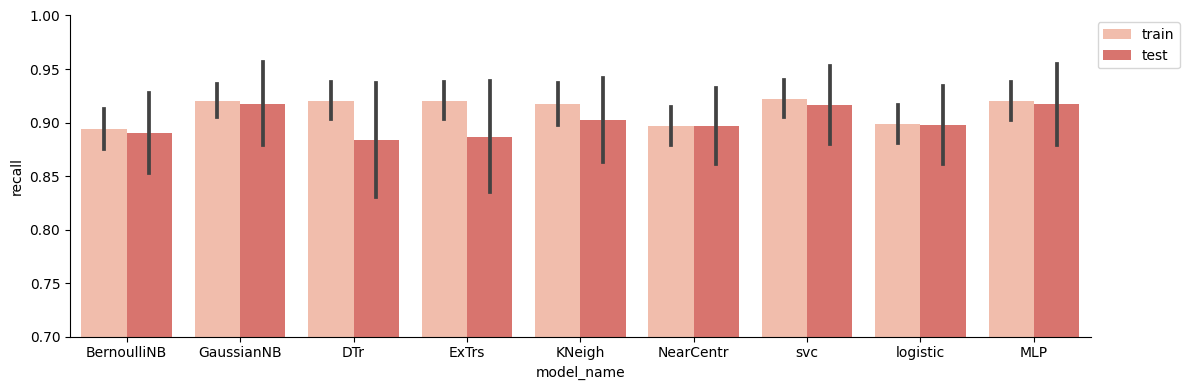

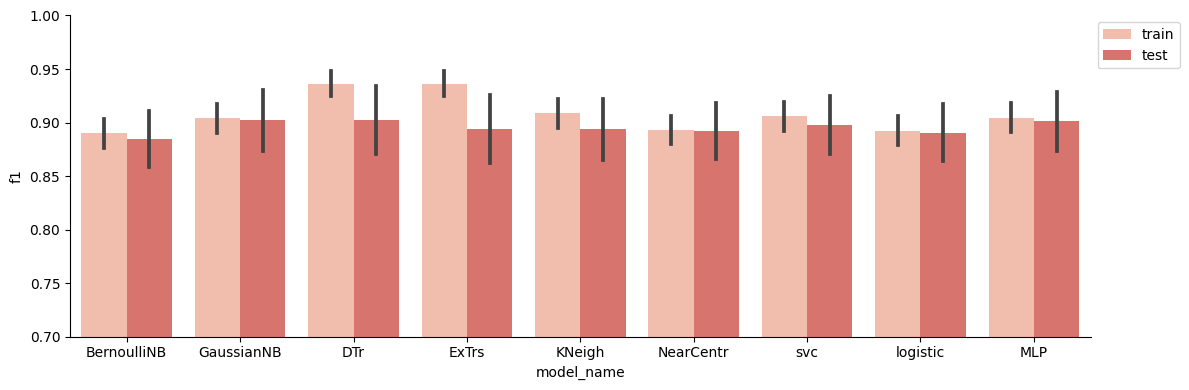

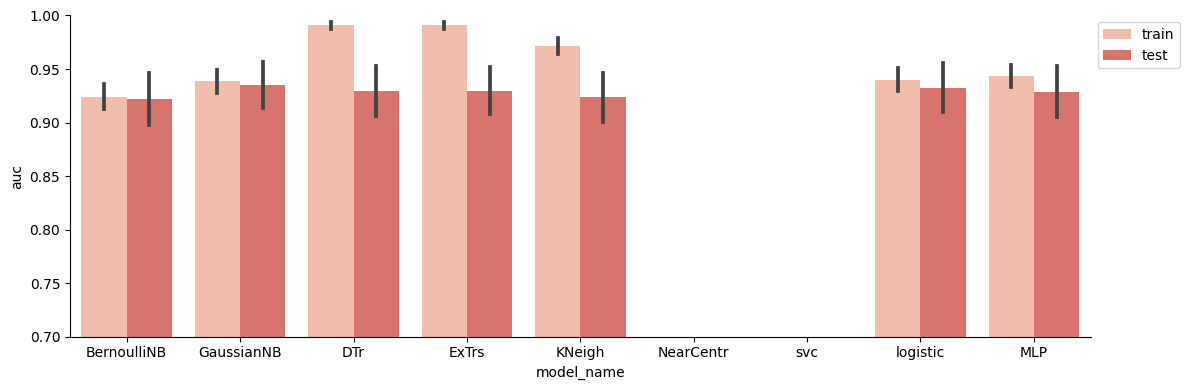

In [10]:
for metric in result_df.columns[3:]:

    fig, ax = plt.subplots(figsize=(12,4))

    sns.barplot(
        data = result_df.filter(['fold_id', 'model_name', 'set'] + [metric]),
        x="model_name", y=metric, hue="set",
        palette="Reds", alpha=.75, ax=ax, errorbar='sd'
    )

    sns.despine(top=True, right=True)

    # Set y-axis limits
    ax.set_ylim(0.7, 1)

    # Move legend outside of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.show()

In [11]:
# Saving Result
result_df.to_csv('Data/ResultsExperiment1.csv')

# Experiment 2

Based on experiment 1 results for recall, which measures the rate of values correctly predicted positive and the real positive, we designate for further exploration and hyperparameter fine-tunning the models:

* _GaussianNB_: with the smallest overfitting in average between training and test sets as well as one of the best performing.
* _MLP_.
* _SVC_. 

For the last two, there's a slighly higher overfitting. The testing set evaluation is less disperse when compared with the Gaussian, with SVC being the most promising on this regard. These two can be also parametrized. Let's try to find parameters that improve the performance of the default parametrization

## MLP Parameter tunning

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# Model to tune
model = MLPClassifier()

# Pipeline for training
_search_pipe = Pipeline([
                        ('scaler', MinMaxScaler()),
                        ('MLP', model)
                    ])

# Parameters for grid search
param_grid = {
    'MLP__hidden_layer_sizes': [(200,), (200,100),(300,200,100), (200,100,50), (300,200,100)],
    'MLP__activation': ['logistic','tanh','relu'],
    'MLP__solver': ['lbfgs', 'adam'],
    'MLP__max_iter': [200,300,400],
    #'MLP__early_stopping': [True],
    #'MLP__validation_fraction': [.25]
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=5, verbose=1, scoring='recall')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'MLP__activation': 'logistic', 'MLP__hidden_layer_sizes': (200,), 'MLP__max_iter': 200, 'MLP__solver': 'adam'}
Best cross-validation score: 0.8968


In [14]:
# Getting the best mlp parameters from the dictionary above
best_mlp_model = MLPClassifier( **{key[5:] : val for key, val in grid_search.best_params_.items()} )

## SVC Parameter tunning

In [15]:
# Model to tune
model = SVC()

# Pipeline for training
_search_pipe = Pipeline([
                        ('scaler', MinMaxScaler()),
                        ('TunedSVC', model)
                    ])

# Parameters for grid search
param_grid = {
    'TunedSVC__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'TunedSVC__degree' : [1,2,3,4,5],
    'TunedSVC__C' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=3, verbose=1, scoring='recall')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation Recall: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters: {'TunedSVC__C': 0.1, 'TunedSVC__degree': 3, 'TunedSVC__kernel': 'poly'}
Best cross-validation Recall: 0.9038


In [16]:
# Getting the best mlp parameters from the dictionary above and adding the probability parameter
best_svc_model = SVC( **{key[10:] : val for key, val in grid_search.best_params_.items()}, probability=True )

# Final Experiment

Besides taking the best 3 classifiers. Let's also merge them into voting and stacking methods to try to improve recall

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [18]:
# Models in Final Experiment
models = {
    'GaussianNB' : GaussianNB(),
    'bestMLP' : best_mlp_model,
    'bestSVC': best_svc_model
}

# Creating Stacking classifier
_stack = StackingClassifier( estimators=list(models.items()), final_estimator=LogisticRegression(), stack_method='predict_proba' )

# Adding Votting
_soft = VotingClassifier(estimators=list(models.items()), voting='soft')
_hard = VotingClassifier(estimators=list(models.items()), voting='hard')

# Adding Keys to Dict
models['stacked'] = _stack
models['hard_vote'] = _hard
models['soft_vote'] = _soft

In [19]:
# Importing cleaned frame
df = cleaned_fr()

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [20]:
_folds, _names, _accuracy, _precision, _recall, _f1, _set_type = [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    #print("*"*88)
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('scaler', MinMaxScaler()),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [21]:
# Saving in DataFrame
result2_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1} )

In [22]:
# Quick  look to the average performance
result2_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])

set,train,test
model_name,,
GaussianNB,0.920259,0.917693
bestMLP,0.920334,0.916612
bestSVC,0.896776,0.895617
hard_vote,0.919688,0.916979
soft_vote,0.914995,0.911275
stacked,0.917919,0.914859


In [23]:
# Quick  look to the average performance
result2_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test'])*100

set,train,test
model_name,,
GaussianNB,1.536121,3.880218
bestMLP,1.733783,3.673514
bestSVC,1.784173,3.633039
hard_vote,1.632869,3.844193
soft_vote,1.608212,4.007388
stacked,1.485124,4.045674


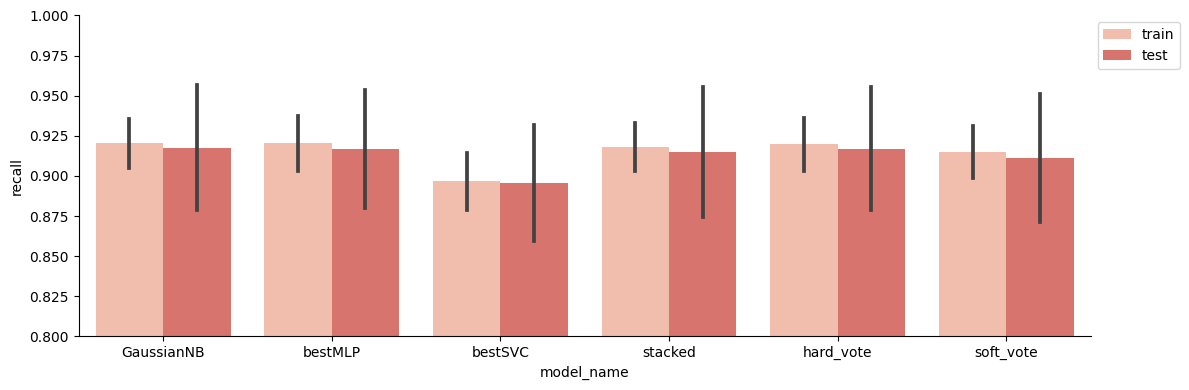

In [27]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result2_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Reds", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.80, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment2_recall.png', dpi=200 )
plt.show()

In [25]:
result2_df.to_csv('Data/ResultsFinalExperiment.csv')